In [1]:
# We import needed packages

import numba as nb
import numpy as np

from pde import PDE, FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, plot_kymograph, movie, ExplicitSolver, Controller # Coming from py-pde, which is not the same than pypde!!!

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The relativistic Euler differential equations are defined as follows:

$$
(1)\:\:\:\:\frac{\partial D}{\partial t}+\frac{\partial f_{1}}{\partial x} = 0,
$$

$$
(2)\:\:\:\:\frac{\partial S}{\partial t}+\frac{\partial f_{2}}{\partial x} = 0,
$$

$$
(3)\:\:\:\:\frac{\partial\tau}{\partial t}+\frac{\partial f_{3}}{\partial x} = 0,
$$

where

$$
D=\rho W=\frac{\rho}{\sqrt{1-u^{2}}},
$$

$$
S=au=\rho h W^{2}u,
$$

$$
\tau=a-p-D=\rho h W^{2}-p-\rho W=\rho W(hW-1)-p,
$$

are the conserved variables and where

$$
W=\frac{1}{\sqrt{1-u^{2}}}\:\:\:\text{is the Lorentz factor,}
$$

$$
\epsilon=\frac{p}{\rho(\gamma-1)}\:\:\:\text{is the specific internal energy,}
$$

$$
h=1+\epsilon+\frac{p}{\rho}=1+\frac{p}{\rho(\gamma-1)}+\frac{p}{\rho}=1+\frac{p}{\rho}\left(1+\frac{1}{\gamma-1}\right)=1+\frac{p\gamma}{\rho(\gamma-1)}\:\:\:\text{is the specific enthalpy.}
$$

On the other hand, the fluxes are defined as

$$
f(W)=(f_{1},f_{2},f_{3})=(Du,Su+p,S-Du)
$$

Moreover, $\rho$, $p$ and $u$ are the density, pressure and velocity of the relativistic fluid, respectively, and $\gamma=1.4$ corresponds to the heat capacity ratio.
The spatial dimension $x$ is partitioned in 400 discretized parts from 0 to 1, while $t$ is discretized from 0 to $t_{f}=0.2$ with $nt=400$.

The initial conditions ($t=0$) are written as follows:

$$ \text{Initial conditions ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho=1 & \text{for all $x$} \\
      p=1 & \text{if $x\leq 0.5$ and $p=10$ else} \\
      u=0.9 & \text{if $x\leq 0.5$ and $u=0$ else} \\
\end{array} 
\right. $$

(We are assuming same initial conditions as the classical approach since we have no further information; at least as placeholder).

After carrying out a procedure of expansion in terms of ($\rho,p,u$) from equation (1), (2) and (3), we arrive at the following derivatives with respect $t$:

$$
(i)\:\:\:\partial_{t}D=-\frac{u}{\sqrt{1-u^{2}}}\partial_{x}\rho-\frac{\rho}{(1-u^{2})^{3/2}}\partial_{x}u
$$

$$
(ii)\:\:\partial_{t}S=-2\frac{\rho u}{1-u^{2}}\left[1+\frac{p}{\rho}\frac{\gamma}{\gamma-1}\right]\partial_{x}u-\left[1+\frac{\gamma}{\gamma-1}\frac{u^{2}}{1-u^{2}}\right]\partial_{x}p-\frac{u^{2}}{1-u^{2}}\partial_{x}\rho
$$

$$
(iii)\:\:\:\partial_{t}\tau=u\left(\frac{1}{\sqrt{1-u^{2}}}-\frac{1}{1-u^{2}}\right)\partial_{x}\rho-\frac{\gamma}{\gamma-1}\frac{u}{1-u^{2}}\partial_{x}p+\frac{\rho}{1-u^{2}}\left[\frac{1}{\sqrt{1-u^{2}}}-1-\frac{p}{\rho}\frac{\gamma}{\gamma-1}\right]\partial_{x}u
$$

In [2]:
nx = 1000 # Number of partitions in space
nt = 1000 # Number of partitions in time
tf = 0.2 # Final time
xf = 1 # Final point
dt = tf/nt # Temporal interval
gamma = 1.4 # Heat capacity ratio

# Let's use a custom class:

class Relativistic_Euler(PDEBase):
        def __init__(self, gamma = 1.4, bc = "neumann"):
            self.gamma = gamma  # Heat Capacity Ratio
            self.bc = bc  # boundary condition
        def evolution_rate(self, state, t=0):
            rho, p, u = state
            gamma = self.gamma
            
            D_t = -(u/(1-u**2)**(1/2)) * rho.gradient(self.bc) - (rho/(1-u**2)**(3/2)) * u.gradient(self.bc)
            S_t = -((2*rho*u)/(1-u**2)) * (1+(gamma*p)/((gamma-1)*rho)) * u.gradient(self.bc) - (1 + (gamma/(gamma-1)) * (u**2/(1-u**2))) * p.gradient(self.bc) - (u**2/(1-u**2)) * rho.gradient(self.bc)
            tau_dt = u * (1/(1-u**2)**(1/2) - 1/(1-u**2)) * rho.gradient(self.bc) - (gamma/(gamma-1)) * (u/(1-u**2)) * p.gradient(self.bc) + (rho/(1-u**2)) * (1/(1-u**2)**(1/2) - 1 - (p/rho)*(gamma/(gamma-1))) * u.gradient(self.bc)
            
            return FieldCollection([D_t, S_t, tau_dt])

In [3]:
# Initial state (Initial conditions, t = 0):

x = np.linspace(0, xf, nx)

ic_rho = lambda x: 1
ic_p = lambda x: 1*(x<=0.5) + 10*(x>0.5)
ic_u = lambda x: 0.9*(x<=0.5)

# Defining grid:
grid = UnitGrid([nx])

rho = ScalarField(grid, ic_rho(x))
p = ScalarField(grid, ic_p(x))
u = ScalarField(grid, ic_u(x))

# Defining state
state = FieldCollection([rho, p, u])

In [4]:
# Simulation
eq = Relativistic_Euler(gamma = 1.4)
storage = MemoryStorage()
solver2 = ExplicitSolver(eq, scheme = "euler", adaptive = False) # It is also possible to select scheme = "rk".
controller2 = Controller(solver2, t_range = tf, tracker = ["progress", storage.tracker(dt)])
sol2 = controller2.run(state, dt = dt)

/home/netzuel/.local/lib/python3.8/site-packages/pde/tools/output.py:60: UserWarning: `tqdm` package is not available. Progress will be indicated by dots.
  warnings.warn(
.../home/netzuel/.local/lib/python3.8/site-packages/pde/fields/base.py:507: RuntimeWarning: invalid value encountered in power
  op(self.data, other, out=result.data)
..

In [5]:
# We export the evolution in time of the variables:

times = []
rho_evolved = []
p_evolved = []
u_evolved = []

for time, field in storage.items():
    times.append(time)
    rho_evolved.append(field[0].data)
    p_evolved.append(field[1].data)
    u_evolved.append(field[2].data)

times = np.array(times) # Shape (nt,)
rho_evolved = np.array(rho_evolved) # Shape (nt, nx)
p_evolved = np.array(p_evolved) # Shape (nt, nx)
u_evolved = np.array(u_evolved) # Shape (nt, nx)

In [6]:
# Let's try to make some 3D plots...

X, T = np.meshgrid(x, times)

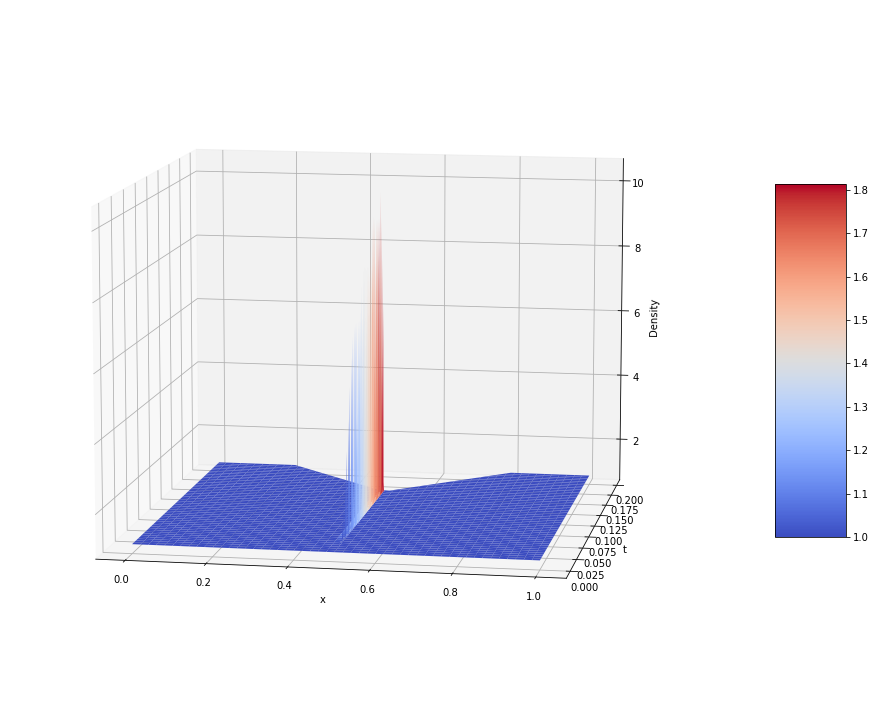

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, rho_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

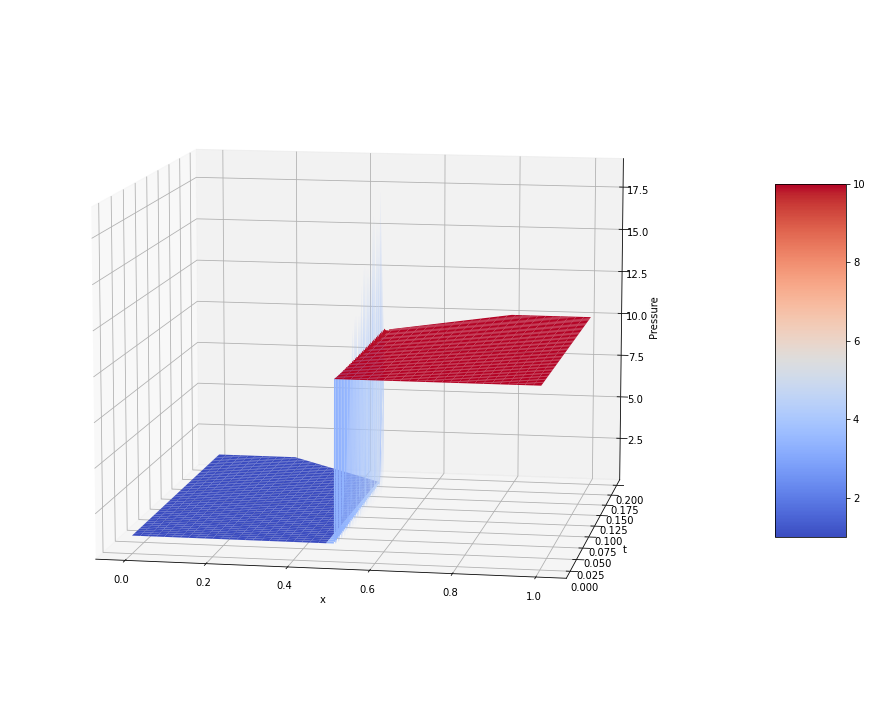

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, p_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10., azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Pressure")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

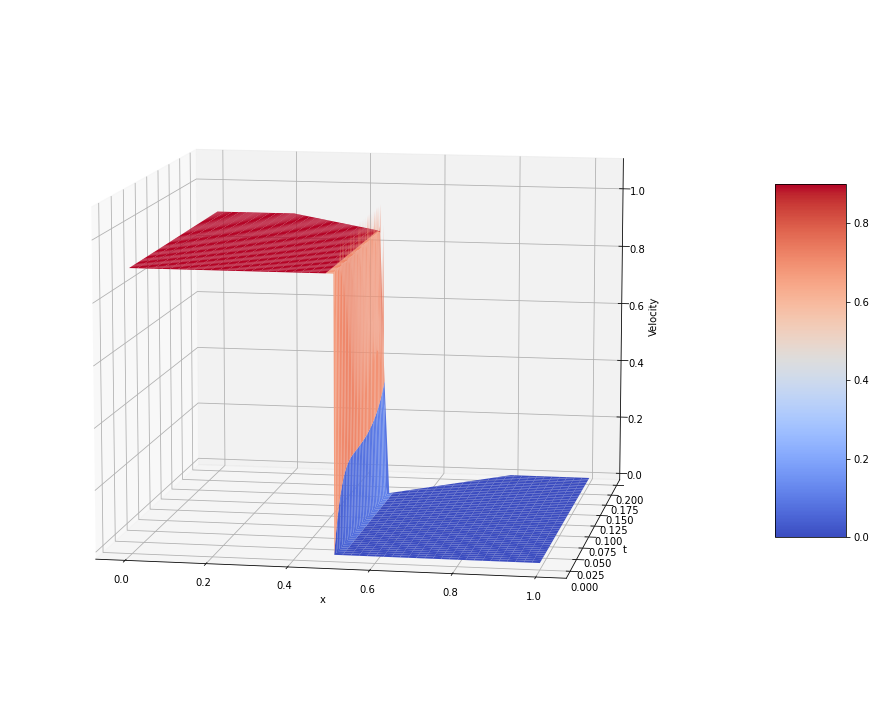

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, u_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10., azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Velocity")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()